In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import glob
from scipy import signal
import niskine 

import mplniw.utils as ut
import mplniw.plot as pl
import mplniw.sigp as sp
import gsw
import pandas as pd
import cmocean as cm

In [2]:
conf = niskine.io.load_config()
m1lon, m1lat, m1bottom_depth = niskine.io.mooring_location(mooring=1)
m2lon, m2lat, m2bottom_depth = niskine.io.mooring_location(mooring=2)
m3lon, m3lat, m3bottom_depth = niskine.io.mooring_location(mooring=3)
root_dir = '/Users/zcasparcohen/codes/NIW/data/'
figdir='/Users/zcasparcohen/codes/NIW/figures_vid/'


In [3]:
ds_filt = xr.open_dataset(root_dir+'roms_filtered_500m.nc')

In [4]:
ds_filt['ke'] = 0.5*(ds_filt.u**2+ds_filt.v**2)
ds_filt['mke'] = 0.5*(ds_filt.u.mean('time')**2+ds_filt.v.mean('time')**2)

In [5]:
ds_filt['eke'] = ds_filt['ke']-ds_filt['mke']

In [6]:

topo = xr.open_dataset('/Users/zcasparcohen/Downloads/ETOPO_2022_v1_30s_N90W180_bed.nc').z.sel(lon=slice(-30,-15.3),lat=slice(55,64.8))
topo = topo.isel(lon=slice(0,None,1),lat=slice(0,None,1))

In [7]:
ds_topo=topo.sel(lon=ds_filt.lon,lat=ds_filt.lat,method='nearest')

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER,LatitudeLocator, LongitudeLocator
import matplotlib.ticker as mticker

In [59]:
subplot_kws=dict(projection=ccrs.LambertConformal(central_longitude=-27.4,central_latitude=60.5),
                 facecolor='white')


for i,t in enumerate(ds_filt.time):
    fig=plt.figure(figsize=[6,6])
    p = ds_filt.ke.isel(time=i).sel(depth=0,method='nearest').plot.contourf(x='lon', y='lat',
                      vmin=0, vmax=5e-1,
                      cmap=cm.cm.solar,
                      subplot_kws=subplot_kws,
                      transform=ccrs.PlateCarree(),
                      levels=51,
                      add_labels=False,
                      add_colorbar=True,
                      cbar_kwargs={'label':r'Kinetic energy [m$^2$s$^{-2}$]','ticks':np.arange(0,5e-1,5e-2)}
                       )
    cs = ds_topo.plot.contour(ax=p.axes,transform=ccrs.PlateCarree(),colors='w',levels=[-1000,-1500],linestyles='-')
    gl = p.axes.gridlines(color='black', alpha=0.5, linestyle='--',draw_labels=True)
    gl.xlabels_top = False
    gl.xlabels_bottom = True
    gl.ylabels_right = False
    #gl.xlines = False
    gl.xlocator = mticker.FixedLocator([-27.7, -27.5,-27.3,-27.1])
    gl.ylocator = mticker.FixedLocator([60.4, 60.5,60.6])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    plt.savefig(figdir+'ke_roms_t%s.png'%i)
    fig.clear(),plt.close()
    #p.axes.scatter([m1lon,m2lon,m3lon],[m1lat,m2lat,m3lat],c='k', transform=ccrs.PlateCarree())
    #p.axes.text(m1lon+0.05,m1lat, 'M1',size=20,transform=ccrs.PlateCarree());p.axes.text(m2lon+0.05,m2lat, 'M2',size=20,transform=ccrs.PlateCarree());
    #p.axes.text(m3lon-0.3,m3lat, 'M3',size=20,transform=ccrs.PlateCarree());


/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in

In [7]:
t_storm = '2001-01-08'
midlon,midlat = ds_filt.lon.median(),ds_filt.lat.median()

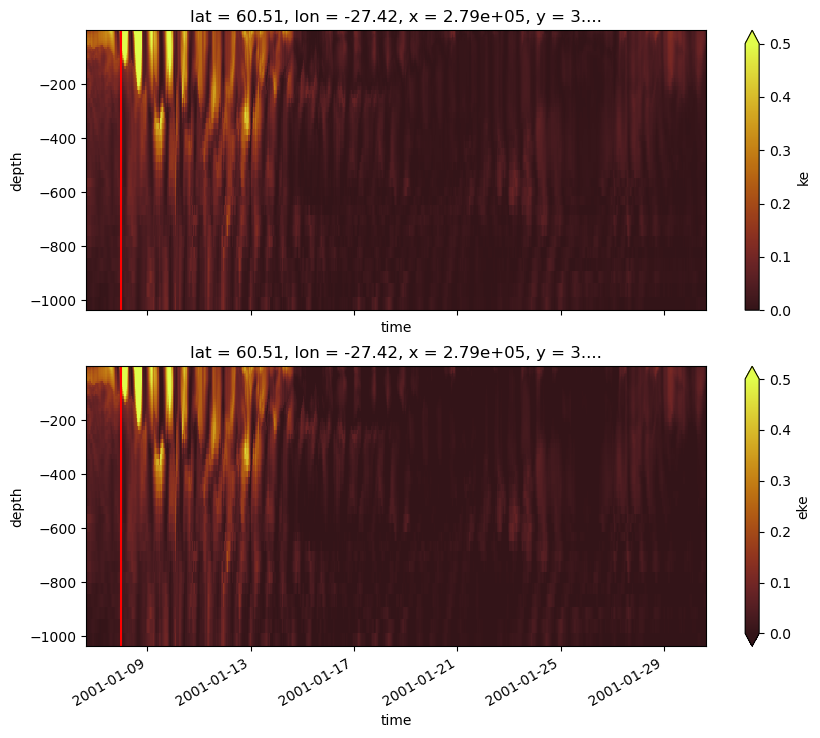

In [8]:
fig,axs=plt.subplots(2,1,figsize=(10,8),sharex=True)
ds_filt.ke.sel(lon=midlon,lat=midlat,method='nearest').plot(ax=axs[0],cmap=cm.cm.solar,vmax=5e-1,vmin=0)
ds_filt.eke.sel(lon=midlon,lat=midlat,method='nearest').plot(ax=axs[1],cmap=cm.cm.solar,vmax=5e-1,vmin=0)
for ax in axs:
    ax.axvline(pd.to_datetime(t_storm),c='r')

In [9]:
t1=pd.to_datetime(t_storm)-pd.Timedelta('6H')

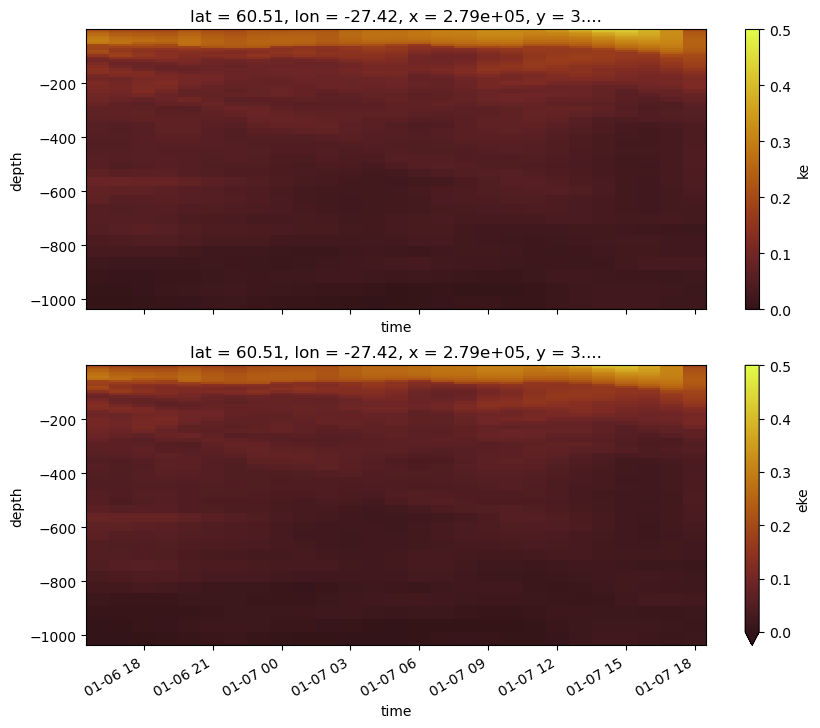

In [10]:
# State before storm:
fig,axs=plt.subplots(2,1,figsize=(10,8),sharex=True)
ds_filt.ke.sel(lon=midlon,lat=midlat,method='nearest').sel(time=slice(None,t1)).plot(ax=axs[0],cmap=cm.cm.solar,vmax=5e-1,vmin=0)
ds_filt.eke.sel(lon=midlon,lat=midlat,method='nearest').sel(time=slice(None,t1)).plot(ax=axs[1],cmap=cm.cm.solar,vmax=5e-1,vmin=0)
#ds_filt.ke.sel(time=slice(None,t1)).isel(time=0,depth=0).plot()

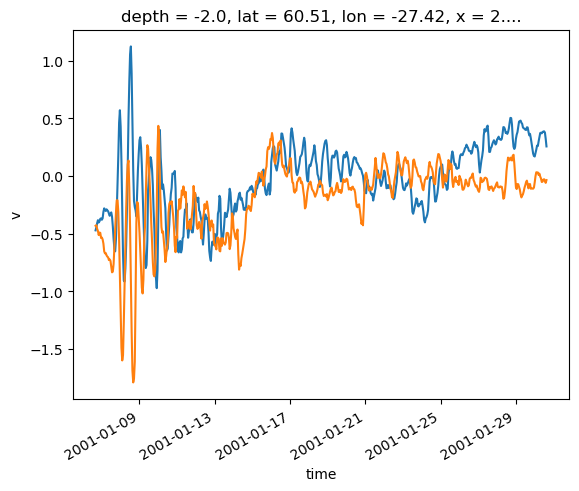

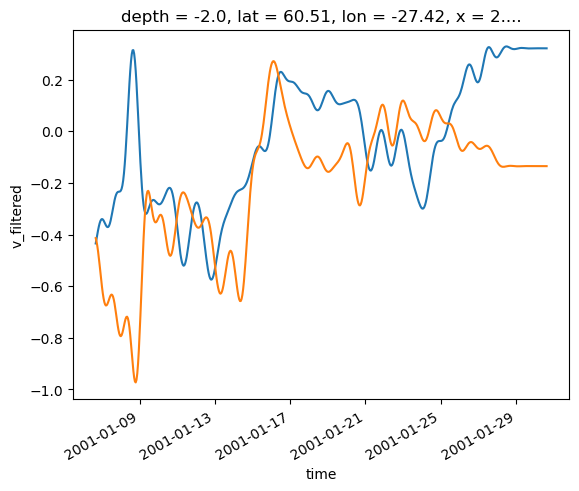

In [11]:
#.sel(time=slice('2001-01-17','2001-01-20'))
ds_filt.u.isel(depth=0).sel(lon=midlon,lat=midlat,method='nearest').plot()
ds_filt.v.isel(depth=0).sel(lon=midlon,lat=midlat,method='nearest').plot()
plt.figure()
ds_filt.u_filtered.isel(depth=0).sel(lon=midlon,lat=midlat,method='nearest').plot()
ds_filt.v_filtered.isel(depth=0).sel(lon=midlon,lat=midlat,method='nearest').plot()

In [12]:
RV=ds_filt.u.differentiate('y')-ds_filt.v.differentiate('x')

In [13]:
RV_low = ds_filt.u_filtered.differentiate('y')-ds_filt.v_filtered.differentiate('x')

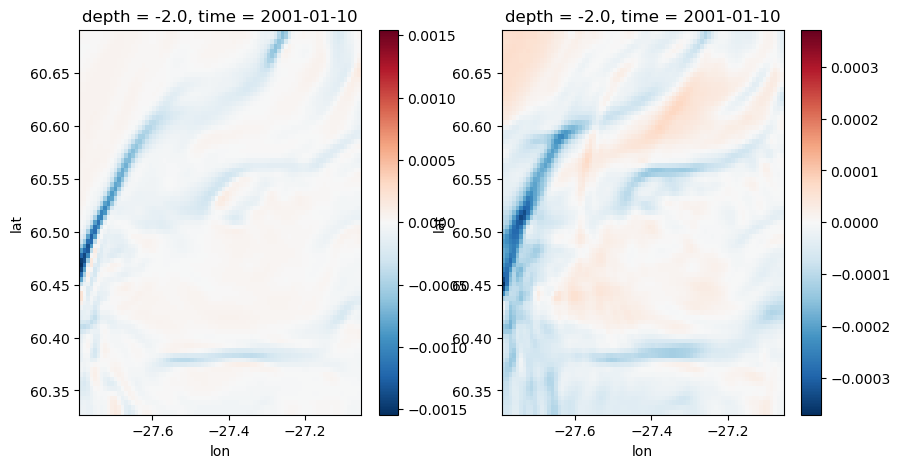

In [18]:
t='2001-01-10'
fig,ax=plt.subplots(1,2,figsize=(10,5))
RV.sel(depth=0,time=t,method='nearest').plot(ax=ax[0])
RV_low.sel(depth=0,time=t,method='nearest').plot(ax=ax[1])

In [14]:
import mplniw.sigp as sp


In [15]:
ds_filt['UV'] = ds_filt.u+1j*ds_filt.v

In [16]:
def _get_E(x, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {
        "window": "hann",
        "return_onesided": False,
        "detrend": None,
        "scaling": "density",
    }
    dkwargs.update(kwargs)
    f, E = signal.welch(x, fs=24.0, axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E


def get_E(v, f=None, **kwargs):
    #v = v.chunk({"time": len(v.time)})
    if "nperseg" in kwargs:
        Nb = kwargs["nperseg"]
    else:
        Nb = 60 * 24
        kwargs["nperseg"] = Nb
    if "return_onesided" in kwargs and kwargs["return_onesided"]:
        Nb = int(Nb/2)+1
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(
            _get_E,
            v,
            dask="parallelized",
            output_dtypes=[np.float64],
            input_core_dims=[["time"]],
            output_core_dims=[["freq_time"]],
            dask_gufunc_kwargs={"output_sizes": {"freq_time": Nb}},
            kwargs=kwargs,
        )
        E = E.assign_coords(freq_time=f).sortby("freq_time")
        E.attrs.update({'long_name':'PSD','units':r'$m^2.s^{-1}$'})
        E.freq_time.attrs.update({'long_name':'Frequency','units':'cpd'})
        return E

In [17]:
test=ds_filt['UV']#.sel(lon=slice(midlon-0.01,midlon+0.01),lat=slice(midlat-0.01,midlat+0.01))

In [18]:
f, E = _get_E(ds_filt['UV'].sel(lon=midlon,lat=midlat,depth=0,method='nearest').values,
              ufunc=False, **{"nperseg":30*24,"return_onesided":False})

/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 720 is greater than input length  = 576, using nperseg = 576
  warnings.warn('nperseg = {0:d} is greater than input length '


In [19]:
E=xr.apply_ufunc(
            _get_E,
            test,
            dask="parallelized",
            output_dtypes=[np.float64],
            input_core_dims=[["time"]],
            output_core_dims=[["freq_time"]],
            dask_gufunc_kwargs={"output_sizes": {"freq_time": 60*24}},
            kwargs={"return_onesided":True,"nperseg":60*24},
        )

/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 1440 is greater than input length  = 576, using nperseg = 576
  warnings.warn('nperseg = {0:d} is greater than input length '
/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


In [20]:
E = E.assign_coords(freq_time=f).sortby("freq_time")
E.attrs.update({'long_name':'PSD','units':r'$m^2.s^{-1}$'})
E.freq_time.attrs.update({'long_name':'Frequency','units':'cpd'})

In [21]:
fc = ut.coriolis(midlat)*3600*24/(2*np.pi)

In [1]:
fig,ax=plt.subplots(figsize=(7,5))
np.log10(E.mean('depth').sel(lon=midlon,lat=midlat,method='nearest')).plot(ax=ax,xlim=(-5,5))
ax.axvline(-fc,c='k');ax.axvline(-fc-0.5,c='k',ls='--');ax.axvline(-fc+0.5,c='k',ls='--');
ax.axvline(0,c='grey');ax.axvline(-0.5,c='grey',ls='--');ax.axvline(0.5,c='grey',ls='--');
ax.grid();ax.set_title('Depth-averaged');
ax.set_ylabel('PSD, log10 scale')

NameError: name 'plt' is not defined

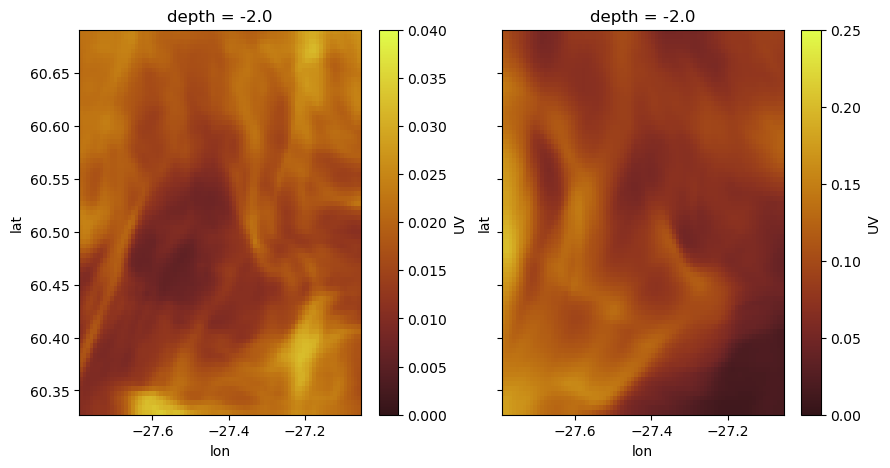

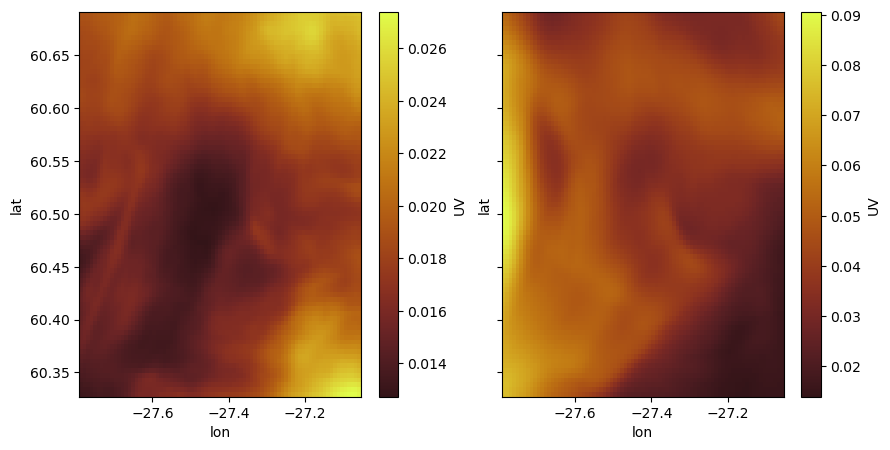

In [23]:
fig,axs=plt.subplots(1,2,figsize=(10,5),sharey=True)
E.isel(depth=0).sel(freq_time=slice(-fc-0.4,-fc+0.4)).integrate('freq_time').plot(ax=axs[0],cmap=cm.cm.solar,vmax=4e-2,vmin=0)
E.isel(depth=0).sel(freq_time=slice(-0.4,0.4)).integrate('freq_time').plot(ax=axs[1],cmap=cm.cm.solar,vmax=2.5e-1,vmin=0)

fig,axs=plt.subplots(1,2,figsize=(10,5),sharey=True)
E.mean('depth').sel(freq_time=slice(-fc-0.4,-fc+0.4)).integrate('freq_time').plot(ax=axs[0],cmap=cm.cm.solar)
E.mean('depth').sel(freq_time=slice(-0.4,0.4)).integrate('freq_time').plot(ax=axs[1],cmap=cm.cm.solar)
#.plot()

Text(0, 0.5, 'PSD, log10 scale')

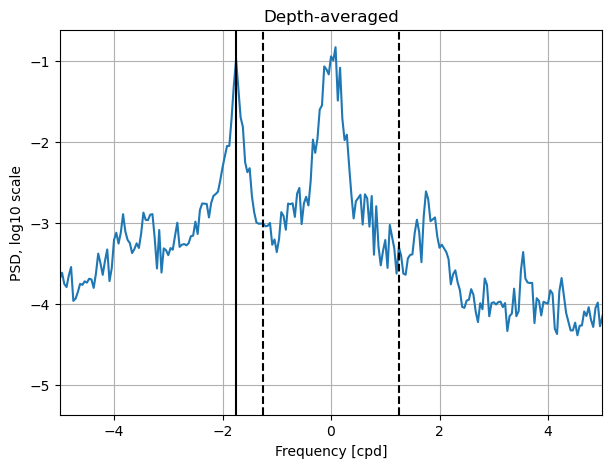

In [24]:
#Filtering frequency
fig,ax=plt.subplots(figsize=(7,5))
np.log10(E.mean('depth').sel(lon=midlon,lat=midlat,method='nearest')).plot(ax=ax,xlim=(-5,5))
ax.axvline(-fc,c='k');ax.axvline(-fc+0.5,c='k',ls='--');ax.axvline(fc-0.5,c='k',ls='--');
#ax.axvline(0,c='grey');ax.axvline(-0.4,c='grey',ls='--');ax.axvline(0.4,c='grey',ls='--');
ax.grid();ax.set_title('Depth-averaged');
ax.set_ylabel('PSD, log10 scale')

In [19]:
ds_filt['ke_filtered']=0.5*(ds_filt.u_filtered**2+ds_filt.v_filtered**2)

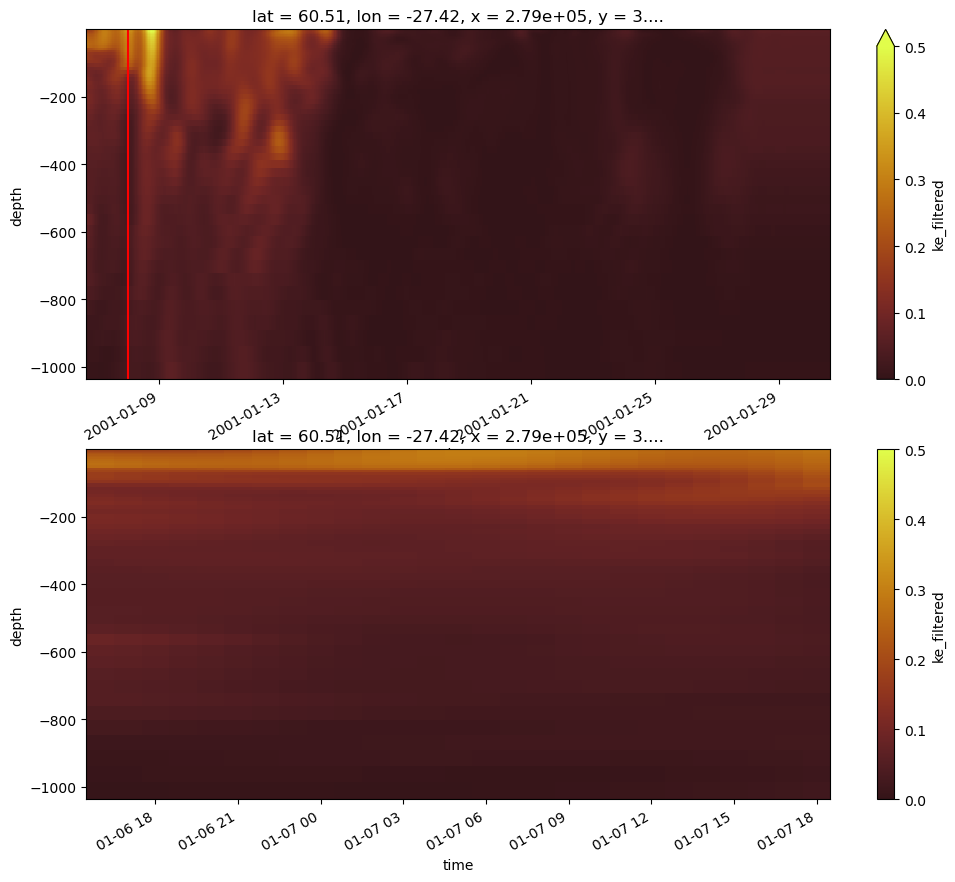

In [20]:
fig,axs=plt.subplots(2,1,figsize=(12,10),sharex=False)
ds_filt.ke_filtered.sel(lon=midlon,lat=midlat,method='nearest').plot(ax=axs[0],cmap=cm.cm.solar,vmax=5e-1,vmin=0)
ds_filt.ke_filtered.sel(time=slice(None,t1)).sel(lon=midlon,lat=midlat,method='nearest').plot(ax=axs[1],cmap=cm.cm.solar,vmax=5e-1,vmin=0)
for ax in axs:
    ax.axvline(pd.to_datetime(t_storm),c='r')